##### Grading Feedback Cell

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Vidushi Mishra <vmishr01@syr.edu>
- Faculty Assistant: Pranav Kottoli Radhakrishna <pkottoli@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include descriptinve title and axis labels.  Plot legends shall be included where possible.  Unless stated otherwise, plots can be made using any Python plotting package.  It is understood that spark data structures must be converted to something like numpy or pandas prior to making plots.  All required mathematical operations, filtering, selection, etc., required by a homework question shall be performed in spark prior to converting to numpy or pandas.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- We reserve the right to take points off for operations that are extremely inefficient or "heavy weight".  This is a big data class and extremely inefficient operations make a big difference when scaling up to large data sets.  For example, the spark dataframe collect() method is a very heavy weight operation and should not be used unless it there is a real need for it.  An example where collect() might be needed is to get ready to make a plot after filtering a spark dataframe.
- import * is not allowed because it is considered a very bad coding practice and in some cases can result in a significant delay (which slows down the grading process) in loading imports.  For example, the statement `from sympy import *` is not allowed.  You must import the specific packages that you need.
- If you perform databricks specific operations, you MUST protect those operations in an if statement by calling the is_databricks() function provided in all homework assignments.  For example, if you use dbutils (databricks utilities), only run dbutils commands if is_databricks() returns true.  Runtime errors created in the grading environment by not protecting databricks specific commands in an if statement will result in a runtime error points deduction. 
- The graders reserve the right to deduct points for subjective things we see with your code.  For example, if we ask you to create a pandas data frame to display values from an investigation and you hard code the values, we will take points off for that.  This is only one of many different things we could find in reviewing your code.  In general, write your code like you are submitting it for a code peer review in industry.  
- Level of effort is part of our subjective grading.  Oftentimes there is a large disparity between the level of effort between students who are trying learn, and students who are trying to do the minimum possible to check off an assignment requirement.  For example, in cases where we ask for a more open ended investigation, some students put in significant effort and some students do the minimum possible to meet requirements.  In these cases, we may take points off for students who did not put in much effort as compared to students who did put in a lot of effort.  We feel that the students who did a better job deserve a better grade.  We reserve the right to invoke level of effort grading at any time.
- Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.
- Unless code is provided which reads data files, __you must use the get_training_filename function povided below to read data files."  Runtime errors encountered while grading caused by students not using get_training_filename will result in a minimum of half points off for the problem in question.__

In [1]:
# Do not delete or change this cell

enable_grid = True

# grading import statements
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
# Correct Usage Example (pass ONLY the full file name):
#   file_name_to_load = get_training_filename("sms_spam.csv") # correct - pass ONLY the full file name  
#   
# Incorrect Usage Example
#   file_name_to_load = get_training_filename("/sms_spam.csv") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("sms_spam.csv/") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("c:/users/will/data/sms_spam.csv") incorrect -pass ONLY the full file name
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "dbfs:/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

# Sentiment Analysis
In this assignment, you will use the tweets.csv file to perform sentiment analysis. The tweets.csv file contains the following columns:
- target: the polarity of the tweet (0 = negative, 4 = positive)
- ids: The id of the tweet ( 2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- flag: The query (lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (robotickilldozr)
- text: the text of the tweet (Lyx is cool)

### Extra Credit for Question 9 and Question 10 were completed.

# Qustion 1: (10 pts)
Read tweets.csv into a spark dataframe named `tweets_df`.  Solutions that do not use `get_training_filename` will be heavily penalized.  Drop all columns except target and text.  Transform the target column such that a negative sentiment is equal to 0 and a positive sentiment is equal to 1.  Determine and print the percentage of positive and negative tweets in the dataframe such that it's easy for the graders to find and interpret your data.

In [2]:
# Your code here
from pyspark.sql.functions import when, count, col

tweets_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(get_training_filename("tweets.csv"))
# get rid of the first column, which is the index of each row
drop_col = ["id", "date", "flag", "user"]
tweets_df = tweets_df.drop(*drop_col)

# transform the 4's to 1 and remaining to 0 
logic_pos = (tweets_df['target'] == 4)
tweets_df = tweets_df.withColumn("target", when(logic_pos == True, 1).otherwise(0))

percentage_df = tweets_df.groupBy('target').count()
percentage_df.withColumn('percentage', percentage_df['count'] / tweets_df.count()).show()

+------+-----+----------+
|target|count|percentage|
+------+-----+----------+
|     1|50000|       0.5|
|     0|50000|       0.5|
+------+-----+----------+



In [3]:
# grading cell do not modify
tweets_pd = tweets_df.toPandas()
display(tweets_pd.head())
print(tweets_pd.shape)

,target,text
0,1,I LOVE @Health4UandPets u guys r the best!!
1,1,im meeting up with one of my besties tonight! ...
2,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
3,1,Being sick can be really cheap when it hurts t...
4,1,@LovesBrooklyn2 he has that effect on everyone


(100000, 2)


##### Grading Feedback Cell

# Question 2: (10 pts)
Pre-process the data by creating a pipeline named `tweets_pre_proc_pipe`. Your pipeline should tokenize, remove stop words, and do a TF-IDF transformation.  Fit and execute your pipeline, and create a new dataframe named `tweets_pre_proc_df`.  Print the shape of the resulting TF-IDF data such that it's easy for the graders to find and understand as num rows x num words. Based on the shape of the TF-IDF data, would you expect a logistic regression model to overfit?

In [4]:
# your code here
import requests
from pyspark.ml import Pipeline
from pyspark.ml.feature import IDF, Tokenizer, CountVectorizer, StopWordsRemover

# obtain the stop words from a website
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

# set filter to remove stopwords
tk = Tokenizer().setInputCol('text').setOutputCol('words')
sw = StopWordsRemover().setStopWords(stop_words).setCaseSensitive(False).setInputCol("words").setOutputCol("filtered")
cv = CountVectorizer().setInputCol("filtered").setOutputCol("tf")
idf = IDF().setInputCol('tf').setOutputCol('tfidf')

tweets_pre_proc_pipe = Pipeline(stages=[tk, sw, cv, idf])
tweets_pre_proc_df = tweets_pre_proc_pipe.fit(tweets_df).transform(tweets_df)

fitted = tweets_pre_proc_pipe.fit(tweets_df)
# print shape of tfidf data
print("num of rows:", fitted.stages[-1].numDocs, "X num of features:", len(fitted.stages[-2].vocabulary))

num of rows: 100000 X num of features: 144214


In [5]:
# grading cell do not modify
display(tweets_pre_proc_df.toPandas().head())

,target,text,words,filtered,tf,tfidf
0,1,I LOVE @Health4UandPets u guys r the best!!,"[i, love, @health4uandpets, u, guys, r, the, b...","[love, @health4uandpets, u, guys, r, best!!]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,im meeting up with one of my besties tonight! ...,"[im, meeting, up, with, one, of, my, besties, ...","[im, meeting, besties, tonight!, wait!!, , -, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.1265280578718189, 0.0, 0.0, 0.0, 0.0, 3.183..."
2,1,"@DaRealSunisaKim Thanks for the Twitter add, S...","[@darealsunisakim, thanks, for, the, twitter, ...","[@darealsunisakim, thanks, twitter, add,, suni...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,Being sick can be really cheap when it hurts t...,"[being, sick, can, be, really, cheap, when, it...","[sick, really, cheap, hurts, eat, real, food, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.1265280578718189, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,@LovesBrooklyn2 he has that effect on everyone,"[@lovesbrooklyn2, he, has, that, effect, on, e...","[@lovesbrooklyn2, effect]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Your explanation here: <br>
The number of rows is 100,000 while the number of features is 144,214. Obviously, the number of features is higher than that of rows, indicating that overfitting might occur. However, it is generally not the number of features itself that will decide if the model have been overfitted or not but rather the method used to train the model with. Nevertheless, overfitting is more prone to happen if the data is sparse. Therefore, it is possible that overfitting might happend in logistic regression model. <br>
In conclusion, if we have too many features (or the so-called high dimentionality), the learned model will try to find the decision boundary to fit the training data set well but it fails to generalize to make the accurate predictions on new dataset.

##### Grading Feedback Cell

# Question 3: (10 pts)
Since IDF considers a word's frequency across all documents in a corpus, you can use IDF as a form of inference.  Examine the documentation for the spark ML object that you used to create TF-IDF scores and learn how to extract the IDF scores for words in the corpus.  Create a pandas dataframe containing the 5 most important IDF scores named `most_imp_idf`.  Create another pandas dataframe containing the 5 least important IDF scores named `least_imp_idf`.  Each dataframe shall have 2 columns named `word` and `idf_score`.  Explain in words your interpretation of what the IDF scores mean.

In [6]:
# your code here
import pandas as pd
from pyspark.sql import functions as fn, Row

# get the idf value
idf_list = tweets_pre_proc_pipe.fit(tweets_df).stages[3].idf
voc = tweets_pre_proc_pipe.fit(tweets_df).stages[2].vocabulary

tf_idf = pd.DataFrame({'idf_score': idf_list.toArray(), 'word': voc}).sort_values('idf_score', ascending = False)
least_imp_idf = tf_idf[-5:]
most_imp_idf = tf_idf.loc[tf_idf['idf_score'] > 10.8197]

In [7]:
# grading cell do not modify
display(most_imp_idf)
display(least_imp_idf)

,idf_score,word
72107,10.819788,tickest
96147,10.819788,http://tweetstats.com
96141,10.819788,provoost
96142,10.819788,together??..
96143,10.819788,bioluminescent
96144,10.819788,requirement.
96145,10.819788,charlotte?
96146,10.819788,stuff..scary.
96148,10.819788,@targuman
96139,10.819788,@team26racing


,idf_score,word
4,3.113850,like
3,3.015945,good
2,2.645649,i'm
1,2.588812,just
0,1.126528,


Your explanation here: <br>
IDF, which is the abbreviation of Inverse Document Frequency, is used to measure how important a term is. Since tf perceive all the terms equally are important, one cannot only use term frequencies to calculate the weight of a term in the document. Therefore, one can weigh down the frequent terms while scaling up the rare ones. Namely, the terms with higher weight scores are considered to be more important. However, in this case, given that some words only appeared once in the document, the idf score is considerably high for those words while most of those words convey little information.

##### Grading Feedback Cell

# Question 4: (10 pts)
Create a new recursive pipeline named `lr_pipe` which starts with `tweets_pre_proc_pipe` and adds a logistic regression model using default hyper parameters.  Fit lr_pipe using `tweets_df`.  Score the model using ROC AUC.  Report the resulting AUC such that it is easy for graders to find and interpret.

In [8]:
# your code here
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

train, test = tweets_df.randomSplit([0.7, 0.3], 0)

lr = LogisticRegression().setLabelCol('target').setFeaturesCol('tfidf')
lr_pipe = Pipeline(stages=[tweets_pre_proc_pipe, lr])
prediction = lr_pipe.fit(train).transform(test)

evaluator = BinaryClassificationEvaluator(labelCol=lr.getLabelCol(), rawPredictionCol=lr.getRawPredictionCol())
auroc = evaluator.evaluate(prediction, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC Curve: {:.4f}".format(auroc))

Area under ROC Curve: 0.7146


##### Grading Feedback Cell

# Question 5: (10 pts)
Create 2 pandas dataframes named `lr_pipe_df_neg` and `lr_pipe_df_pos`which contain 2 colunms: `word` and `score`.  Load the 2 dataframes with the top 10 words and logistic regression coefficients that contribute the most to negative and positive sentiments respectively. Analyze the 2 dataframes and describe if the words make sense.  Do the words look like they are really negative and positive?

In [9]:
# your code here
fitted_lr_pipe = lr_pipe.fit(train)
vocabulary = fitted_lr_pipe.stages[0].stages[2].vocabulary
score = fitted_lr_pipe.stages[-1].coefficients.toArray()

lr_pipe_df = pd.DataFrame({'word': vocabulary, 'score': score}).sort_values('score', ascending = False)
lr_pipe_df_pos = lr_pipe_df[:10]
lr_pipe_df_neg = lr_pipe_df[-10:]

In [10]:
# grading cell - do not modify
display(lr_pipe_df_neg)
display(lr_pipe_df_pos)

,word,score
102418,man..can't,-6.252497
106035,sketchersizing,-6.252671
75721,wait?!?!?!,-6.344733
55418,towers...,-6.420884
63135,guurl..,-6.460265
38828,@chelkface,-6.473253
57304,pointless.,-6.612166
77473,chelsee,-6.764122
8195,gig?,-6.976705
70976,"plunger,never",-7.036870


,word,score
91707,@bitter_like_you,10.134811
53957,sstill,9.775935
110149,fast...oh,8.971023
91852,@jazavis,7.763052
20257,amesterdam,6.910309
46770,front!,6.908521
71523,warmth!!,6.709632
55695,probbaly,6.517547
8694,stop!,6.402478
91363,aaf,6.397224


Your explanation here:<br>
The two dataframes contain the negative or positive words with the corresponding score. The scores of positive words are all above 0 while those of negative words are all below 0. If we carefully analyze those words, one can find that those words do not look like very negative and positive. Most of them even don't make sense.

##### Grading Feedback Cell

# Question 6a: (5 pts)
The goal of this question is to try to improve the score from question 4 using a regularization grid search on a new pipeline named `lr_pipe_1`. lr_pipe_1 is the same as lr_pipe above but we would like you to create a new pipe for grading purposes only.  I'm not sure if it's possible to increase the score or not.  You will be graded on level of effort to increase the score in relation to other students in the class.  All of your grid search code should be inside the `if enable_grid` statement in the cell below.  The enable_grid boolean is set to true in a grading cell above.  If any of the grid search code executes outside of the if statement, you will not get full credit for the question.  We want the ability to turn off the grid search during grading.<br>

In [11]:
# your grid search (and only your grid search) code here
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

if enable_grid:
    # your grid search code here
    # elasticNetParam corresponds to α and regParam corresponds to λ
    grid = ParamGridBuilder().addGrid(lr.elasticNetParam, [0.2, 0.1, 0.01, 0.001, 0]).addGrid(lr.regParam, [0., 0.01, 0.1]).build()
    lr_pipe_1 = CrossValidator(estimator=lr_pipe, 
                               estimatorParamMaps=grid, 
                               evaluator=evaluator,
                               numFolds=3)
    fitted_lr_pipe_1 = lr_pipe_1.fit(train)
    print(evaluator.evaluate(fitted_lr_pipe_1.bestModel.transform(test), {evaluator.metricName: "areaUnderROC"}))

0.8234022098771081


##### Grading feedback cell

# Question 6b (5 pts)
Build a new pipeline named `lr_pipe_2` which uses the optimized model parameters from the grid search in question 6a above (the best model).  Create 2 variables named alpha and lambda and assign to them the best alpha and lambda produced by the grid search by hard coding the values. Fit and transform lr_pipe_2.  Compare AUC scores between lr_pipe_2 with lr_pipe in question 4.  Create a pandas dataframe named `comapre_1_df` which encapsulates the comparison data.  comapre_1_df Shall have 2 columns: `model_name` and `auc_score`.

In [12]:
# your optimized model code here
# example
lr_alpha = 0.1
lr_lambda = 0.01

# lr_pipe_2 code here
lr_2 = LogisticRegression().setLabelCol('target').setFeaturesCol('tfidf').setRegParam(lr_lambda).setElasticNetParam(lr_alpha)
lr_pipe_2 = Pipeline(stages=[tweets_pre_proc_pipe, lr_2])
# fit and transform lr_pipe_2
lr_pipe_2_result = lr_pipe_2.fit(train).transform(test)
auroc2 = evaluator.evaluate(lr_pipe_2_result, {evaluator.metricName: "areaUnderROC"})

model_name = ['lr_pipe', 'lr_pipe_2']
auc_scores = [auroc, auroc2]
comapre_1_df = pd.DataFrame({'model_name': model_name, 'auc_score': auc_scores})

In [13]:
# grading cell - do not modify
display(comapre_1_df)

,model_name,auc_score
0,lr_pipe,0.714612
1,lr_pipe_2,0.822490


##### Grading Feedback Cell

# Question 7 (10 pts)
Perform inference on lr_pipe_2.  Write code to report how many words were eliminated from the best model in question 6b above (if any) as compared to the model in question 4 above.  Make sure your output is easy for the graders to find and interpret.

In [15]:
# your code here
# given that we have already assign the best parameter to the lr_2 logistic regression object, 
# we can use the lr_pipe_2 as the best model
fitted_lr_pipe_2 = lr_pipe_2.fit(train)

diff = fitted_lr_pipe.stages[-1].numFeatures - fitted_lr_pipe_2.stages[-1].numFeatures
print("number of eliminated features:", diff)

number of eliminated features: 0


##### Grading Feedback Cell

# Question 8 (10 pts)
Perform the same inference analysis that you did in question 5 but name the data frames `lr_pipe_df_neg_1` and `lr_pipe_df_pos_1`.  Compare the word importance results with the results in question 5.

In [16]:
# your code here
vocabulary_2 = fitted_lr_pipe_2.stages[0].stages[-2].vocabulary
score_2 = fitted_lr_pipe_2.stages[-1].coefficients.toArray()

lr_pipe_df_2 = pd.DataFrame({'word': vocabulary_2, 'score': score_2}).sort_values('score', ascending = False)
lr_pipe_df_pos_1 = lr_pipe_df_2[:10]
lr_pipe_df_neg_1 = lr_pipe_df_2[-10:]

In [17]:
# grading cell - do not modify
display(lr_pipe_df_neg_1)
display(lr_pipe_df_pos_1)

,word,score
156,poor,-0.464324
832,sadly,-0.467897
37,wish,-0.478714
171,missing,-0.479152
83699,@theu4life219,-0.483204
63639,@billipipers,-0.520261
57593,@stigblog,-0.548671
34,miss,-0.562012
55,sad,-0.618670
51739,"me,but",-0.648742


,word,score
53856,sstill,1.084409
108428,front!,0.721063
57451,soar.,0.663046
55594,probbaly,0.584322
33966,"specialist,",0.574190
87901,gurpreet,0.566776
99143,michiganders,0.566021
91358,this!!!!,0.548309
29655,usa...,0.540402
101035,@jakular,0.539177


##### Grading Feedback Cell

Your explanation here:<br>
Some of the top 10 negative words are more informative than those negative words obtained above, such as sad, poor, and sorry. However, the majority of the top 10 positive words, still, don't make sense. On some rare occasions, words like "..good" will also appear in the positive dataframe.

##### Grading Feedback Cell

# Question 9 (10 pts)
Create a receiver operating characteristic (ROC) plot for the best model in question 6.  Briefly describe in words the high level steps needed to build a ROC curve as outlined in lecture.  Convince me you understand the high level steps needed to make a ROC curve.

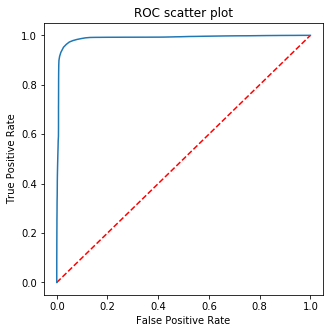

In [18]:
# your code here
import matplotlib.pyplot as plt

# To get the FPR and TPR
FPR = fitted_lr_pipe_2.stages[-1].summary.roc.select('FPR').collect()
TPR = fitted_lr_pipe_2.stages[-1].summary.roc.select('TPR').collect()

# Using those two variables to draw a plot
%matplotlib inline
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(FPR, TPR)
plt.title("ROC scatter plot")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The ROC curve is 0.8224976212306587


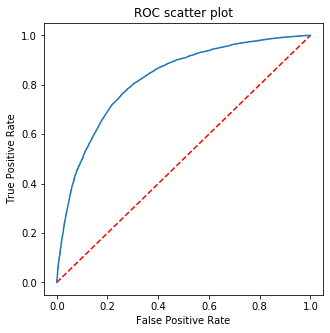

In [20]:
# extra credit for question 9
from sklearn.metrics import roc_curve, roc_auc_score

prediction = fitted_lr_pipe_2.transform(test).select('target','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['target']))).collect()
lr_prob, lr_lable = zip(*prediction)
fpr, tpr, threshold = roc_curve(lr_lable, lr_prob)
print("The ROC curve is", roc_auc_score(lr_lable, lr_prob))

# # Using those two variables to draw a plot
%matplotlib inline
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr)
plt.title("ROC scatter plot")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Your explanation here:<br>
ROC curve is a useful tool to predict the probability of a binary outcome. It is a plot which has false positive rate on x-axis and has true positive rate on y-axis for a number of different candidate threshold values between 0 and 1. Specifically, <b> the true positive rate is calculated as the number of true positives divided by the sum of the number of true positives and the number of false negatives </b>. This rate indicates how good the model is at predicting the positive class when the actual outcome is positive. The <b> false positive rate is calculated as the number of false positives divided by the sum of the number of false positives and the number of true negatives </b>. This value summarizes how often a positive class is predicted when the actual outcome is negative. <br>
For <b> the first method </b>, one can simply use the logistic regression summary model to get the FPR and TPR values. <br>
For <b> the second method </b>, given that we want to get the actual result of the test dataset. We can extract the "target" and pridicted "probability" from the transformed model. Then, by assigning "target" as the actual label and assiging "probability" as the pridicted result, one can use the roc_curve function from the sklearn.metrics package  to calculate the FPR and TPR values.
After obtaining those two variables, one can use the plot function to generate a line graph.

##### Grading Feedback Cell

# Question 10 (10 pts)
Learn about [precision/recall](https://en.wikipedia.org/wiki/Precision_and_recall) curves. Using the logistic regression summary object contained in the linear regression object within lr_pipe_2, create a precision recall plot. Similar to the `roc` object which is available in the logistic regression summary, there is a `pr` object which can be used to help create a precision / recall curve.  Note that the precision recall curve is built using the same high level methodology as the ROC curve, but using different metrics calculated from the confusion matrix.  If you understand how a ROC curve is built, you understand how a precision / recall curve is built.  Compare and contrast the differences between precision / recall and ROC curves.  What axis is common and what axis is different between the 2 curves?

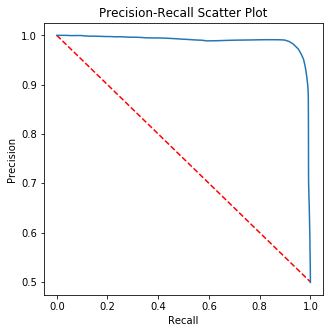

In [29]:
# your code here
recall = fitted_lr_pipe_2.stages[-1].summary.pr.select("recall").collect()
precision = fitted_lr_pipe_2.stages[-1].summary.pr.select("precision").collect()

%matplotlib inline
plt.figure(figsize=(5,5))
plt.plot([0, 1], [1, 0.5], 'r--')
plt.plot(recall, precision)
plt.title("Precision-Recall Scatter Plot")
plt.xlabel('Recall')
plt.ylabel('Precision')
display()

The auc of PR is 0.8087547304963955


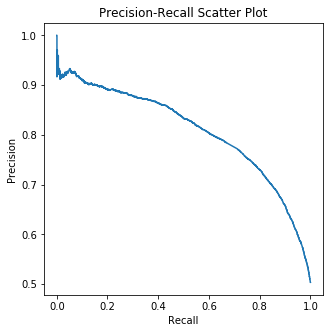

In [32]:
# extra credit for question 10
from sklearn.metrics import precision_recall_curve, auc

prediction = fitted_lr_pipe_2.transform(test).select('target','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['target']))).collect()
lr_probs, lr_lables = zip(*prediction)
lr_precision, lr_recall, _ = precision_recall_curve(lr_lables, lr_probs)
print("The auc of PR is", auc(lr_recall, lr_precision))

# # Using those two variables to draw a plot
%matplotlib inline
plt.figure(figsize=(5,5))
plt.plot(lr_recall, lr_precision)
plt.title("Precision-Recall Scatter Plot")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Your explanation here: <br>
Similar to ROC plot, Precision-Recall plot is another graphing tool which can be used to evaluate the performance of model. A precision-recall curve is a plot of the precision (y-axis) and the recall (x-axis) for different thresholds. <br>
<b> Precision is a ratio of the number of true positives divided by the sum of the true positives and false positives </b>. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value. <b> Recall is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives </b>. Recall is the same as the true positive rate.
<br>
For <b> the first method </b>, one can simply use the logistic regression summary model to get the precision and recall values. <br>
For <b> the second method </b>, we can extract the "target" and pridicted "probability" from the transformed model. Then, by assigning "target" as the actual label and assiging "probability" as the pridicted result, one can use the precision_recall_curve function from the sklearn.metrics package to calculate the precision and recall values.

##### Grading Feedback Cell